In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers

import PIL
import PIL.Image
import pathlib
from PIL import Image
import pickle

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.6.0


In [4]:
#Melakukan mounting dari google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#Melakukan copy data dari google drive ke local data google colab
!cp -r /content/gdrive/MyDrive/Kaggle/state-farm-distracted-driver-detection.zip /content

In [5]:
#Melakukan unzip dari data yang sudah dicopy
!unzip /content/state-farm-distracted-driver-detection.zip


Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [5]:
mypath= r'imgs/train/'

In [6]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [7]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
c0    2489
c1    2267
c2    2317
c3    2346
c4    2326
c5    2312
c6    2325
c7    2002
c8    1911
c9    2129
dtype: int64

In [8]:
df.head()


,path,file_name,tag
0,imgs/train/c5/img_81822.jpg,img_81822.jpg,c5
1,imgs/train/c5/img_24142.jpg,img_24142.jpg,c5
2,imgs/train/c5/img_39241.jpg,img_39241.jpg,c5
3,imgs/train/c5/img_91645.jpg,img_91645.jpg,c5
4,imgs/train/c5/img_16473.jpg,img_16473.jpg,c5


In [36]:
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [37]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [38]:
# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

In [39]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [15]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 17939
val size 2242
test size 2243


In [16]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag
test        c0      247
            c1      246
            c2      239
            c3      238
            c4      242
            c5      224
            c6      198
            c7      210
            c8      188
            c9      210
train       c0     1974
            c1     1795
            c2     1849
            c3     1876
            c4     1812
            c5     1885
            c6     1897
            c7     1605
            c8     1526
            c9     1720
validation  c0      268
            c1      226
            c2      229
            c3      232
            c4      272
            c5      203
            c6      230
            c7      187
            c8      197
            c9      199
dtype: int64 




,path,tag,set
21415,imgs/train/c2/img_93401.jpg,c2,validation
2390,imgs/train/c9/img_54777.jpg,c9,train
2771,imgs/train/c6/img_101610.jpg,c6,train


In [17]:
import shutil
from tqdm.notebook import tqdm as tq

In [18]:
datasource_path = r'imgs/train/'
dataset_path = "dataset/"

In [19]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [20]:
df_te.head()

,path,tag,set
2893,imgs/train/c4/img_42583.jpg,c4,test
18328,imgs/train/c8/img_9596.jpg,c8,test
15788,imgs/train/c7/img_78220.jpg,c7,test
16670,imgs/train/c9/img_100499.jpg,c9,test
3434,imgs/train/c4/img_97689.jpg,c4,test


In [9]:
train_folder=r'dataset/train/'
test_folder=r'dataset/test/'
val_folder=r'dataset/validation/'

In [10]:
import pathlib
train_dir = pathlib.Path(train_folder)
val_dir=pathlib.Path(val_folder)
test_dir = pathlib.Path(test_folder)

image_count = len(list(train_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))

print(image_count)
print(test_count)
print(val_count)

17939
2242
2243


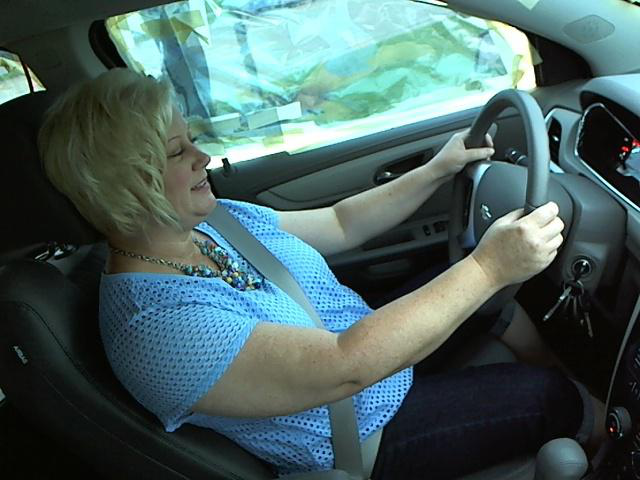

In [11]:
#Ambil contoh gambar
drive = list(train_dir.glob('c0/*'))
PIL.Image.open(str(drive[20]))

In [ ]:
df = pd.read_csv('driver_imgs_list.csv')

## Data Preprocessing

In [12]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))
val_ds = val_ds.shuffle(val_count, reshuffle_each_iteration=False)

In [13]:
for f in train_ds.take(5):
  print(f.numpy())

b'dataset/train/c0/img_31785.jpg'
b'dataset/train/c0/img_32994.jpg'
b'dataset/train/c6/img_91540.jpg'
b'dataset/train/c3/img_22625.jpg'
b'dataset/train/c3/img_70456.jpg'


In [14]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [15]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [16]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [17]:
class_names = np.array(sorted([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']


In [18]:
batch_size = 32
img_height = 64
img_width = 64


In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

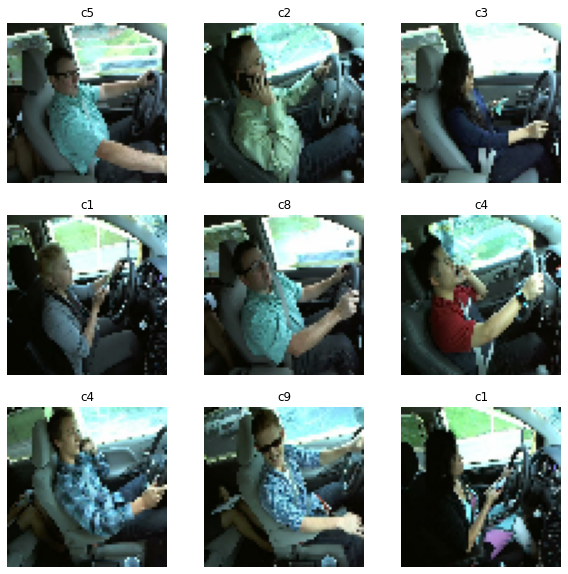

In [21]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [22]:
normalization_layer = layers.Rescaling(1./255)


In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
#Definisi Model CNN yang akan digunakan
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [25]:
#Compiling model CNN
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
#Training Model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10)

Epoch 1/10
561/561 [==============================] - 72s 71ms/step - loss: 0.8474 - accuracy: 0.7105 - val_loss: 0.2245 - val_accuracy: 0.9385
Epoch 2/10
561/561 [==============================] - 5s 9ms/step - loss: 0.1525 - accuracy: 0.9564 - val_loss: 0.1190 - val_accuracy: 0.9661
Epoch 3/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0774 - accuracy: 0.9772 - val_loss: 0.0911 - val_accuracy: 0.9737
Epoch 4/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0569 - accuracy: 0.9829 - val_loss: 0.1004 - val_accuracy: 0.9666
Epoch 5/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0375 - accuracy: 0.9879 - val_loss: 0.0722 - val_accuracy: 0.9786
Epoch 6/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0921 - val_accuracy: 0.9773
Epoch 7/10
561/561 [==============================] - 5s 9ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0730 - val_accuracy: 0.9835
Epoc

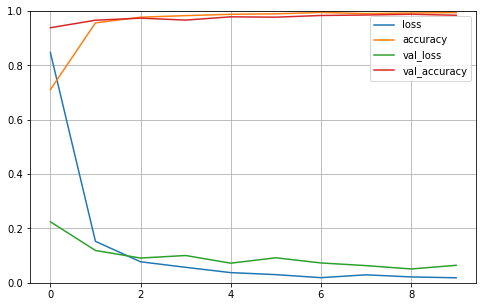

In [27]:
#Plotting hasil training
pd.DataFrame(history.history).plot(figsize =( 8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


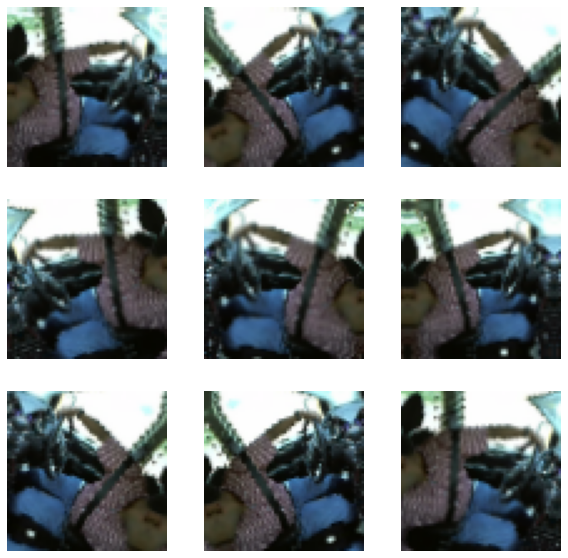

In [29]:
#Plotting contoh data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model2 = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)       

In [33]:
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
561/561 [==============================] - 9s 14ms/step - loss: 1.7436 - accuracy: 0.3648 - val_loss: 1.0711 - val_accuracy: 0.6202
Epoch 2/10
561/561 [==============================] - 7s 13ms/step - loss: 0.9497 - accuracy: 0.6714 - val_loss: 0.5732 - val_accuracy: 0.8154
Epoch 3/10
561/561 [==============================] - 8s 13ms/step - loss: 0.6377 - accuracy: 0.7857 - val_loss: 0.4290 - val_accuracy: 0.8591
Epoch 4/10
561/561 [==============================] - 7s 13ms/step - loss: 0.4747 - accuracy: 0.8416 - val_loss: 0.3368 - val_accuracy: 0.8894
Epoch 5/10
561/561 [==============================] - 7s 13ms/step - loss: 0.3988 - accuracy: 0.8696 - val_loss: 0.2802 - val_accuracy: 0.9108
Epoch 6/10
561/561 [==============================] - 7s 12ms/step - loss: 0.3291 - accuracy: 0.8942 - val_loss: 0.2924 - val_accuracy: 0.9091
Epoch 7/10
561/561 [==============================] - 7s 13ms/step - loss: 0.2950 - accuracy: 0.9061 - val_loss: 0.2054 - val_accuracy: 0.9336

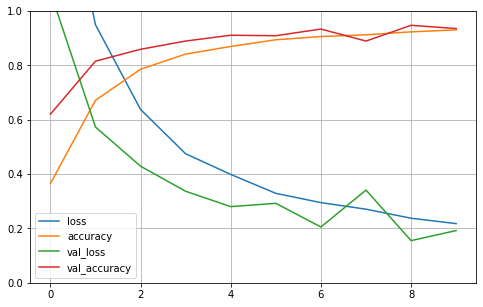

In [34]:
#Plotting hasil model improvement
pd.DataFrame(history.history).plot(figsize =( 8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [40]:
df_te.head()

,path,tag,set
2893,imgs/train/c4/img_42583.jpg,c4,test
18328,imgs/train/c8/img_9596.jpg,c8,test
15788,imgs/train/c7/img_78220.jpg,c7,test
16670,imgs/train/c9/img_100499.jpg,c9,test
3434,imgs/train/c4/img_97689.jpg,c4,test


In [42]:
labels = df_te["tag"].values
imgs = df_te["path"].values

In [43]:
data =[]
for img in imgs:
    path = tf.keras.utils.get_file(origin='file:///content/' + img)
    image = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model2.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predi = class_names[np.argmax(score)]
    data.append(predi)

Streaming output truncated to the last 5000 lines.
57344/44438 [======================================] - 0s 0us/step


In [45]:
y_pred = np.array(data)
y_pred = [str(i) for i in y_pred]
y_pred

['c4',
 'c8',
 'c7',
 'c9',
 'c4',
 'c3',
 'c0',
 'c6',
 'c9',
 'c6',
 'c2',
 'c0',
 'c5',
 'c7',
 'c3',
 'c2',
 'c9',
 'c0',
 'c1',
 'c4',
 'c3',
 'c4',
 'c0',
 'c4',
 'c7',
 'c3',
 'c5',
 'c1',
 'c1',
 'c4',
 'c8',
 'c7',
 'c8',
 'c5',
 'c5',
 'c3',
 'c2',
 'c6',
 'c1',
 'c4',
 'c8',
 'c9',
 'c9',
 'c0',
 'c6',
 'c6',
 'c2',
 'c5',
 'c5',
 'c4',
 'c7',
 'c4',
 'c2',
 'c0',
 'c9',
 'c9',
 'c5',
 'c0',
 'c9',
 'c1',
 'c1',
 'c5',
 'c7',
 'c2',
 'c0',
 'c0',
 'c2',
 'c2',
 'c0',
 'c7',
 'c6',
 'c3',
 'c6',
 'c1',
 'c8',
 'c5',
 'c2',
 'c7',
 'c5',
 'c0',
 'c0',
 'c5',
 'c7',
 'c8',
 'c1',
 'c1',
 'c8',
 'c3',
 'c8',
 'c2',
 'c1',
 'c9',
 'c2',
 'c3',
 'c2',
 'c4',
 'c7',
 'c4',
 'c6',
 'c6',
 'c0',
 'c6',
 'c7',
 'c1',
 'c3',
 'c6',
 'c0',
 'c5',
 'c1',
 'c3',
 'c2',
 'c6',
 'c5',
 'c0',
 'c9',
 'c4',
 'c8',
 'c3',
 'c1',
 'c4',
 'c9',
 'c5',
 'c3',
 'c3',
 'c2',
 'c9',
 'c3',
 'c4',
 'c9',
 'c9',
 'c0',
 'c4',
 'c3',
 'c5',
 'c2',
 'c5',
 'c8',
 'c4',
 'c1',
 'c4',
 'c2',
 'c3',
 'c7',

In [48]:
y_test = df_te["tag"].values
y_test

array(['c4', 'c8', 'c7', ..., 'c1', 'c0', 'c4'], dtype=object)

In [49]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, y_pred)

In [50]:
cf

array([[241,   0,   0,   0,   1,   0,   0,   0,   1,   4],
       [  2, 242,   0,   0,   0,   0,   2,   0,   0,   0],
       [  2,   0, 236,   0,   0,   0,   1,   0,   0,   0],
       [ 14,   0,   0, 211,  10,   0,   0,   0,   0,   3],
       [  8,   0,   0,   0, 234,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 218,   0,   1,   0,   5],
       [  0,   5,   4,   0,   0,   0, 185,   0,   4,   0],
       [  1,   3,   3,   0,   0,   0,   1, 193,   9,   0],
       [  6,   1,  10,   0,   3,   0,  10,   7, 145,   6],
       [ 22,   1,   0,   0,   0,   0,   1,   0,   5, 181]])

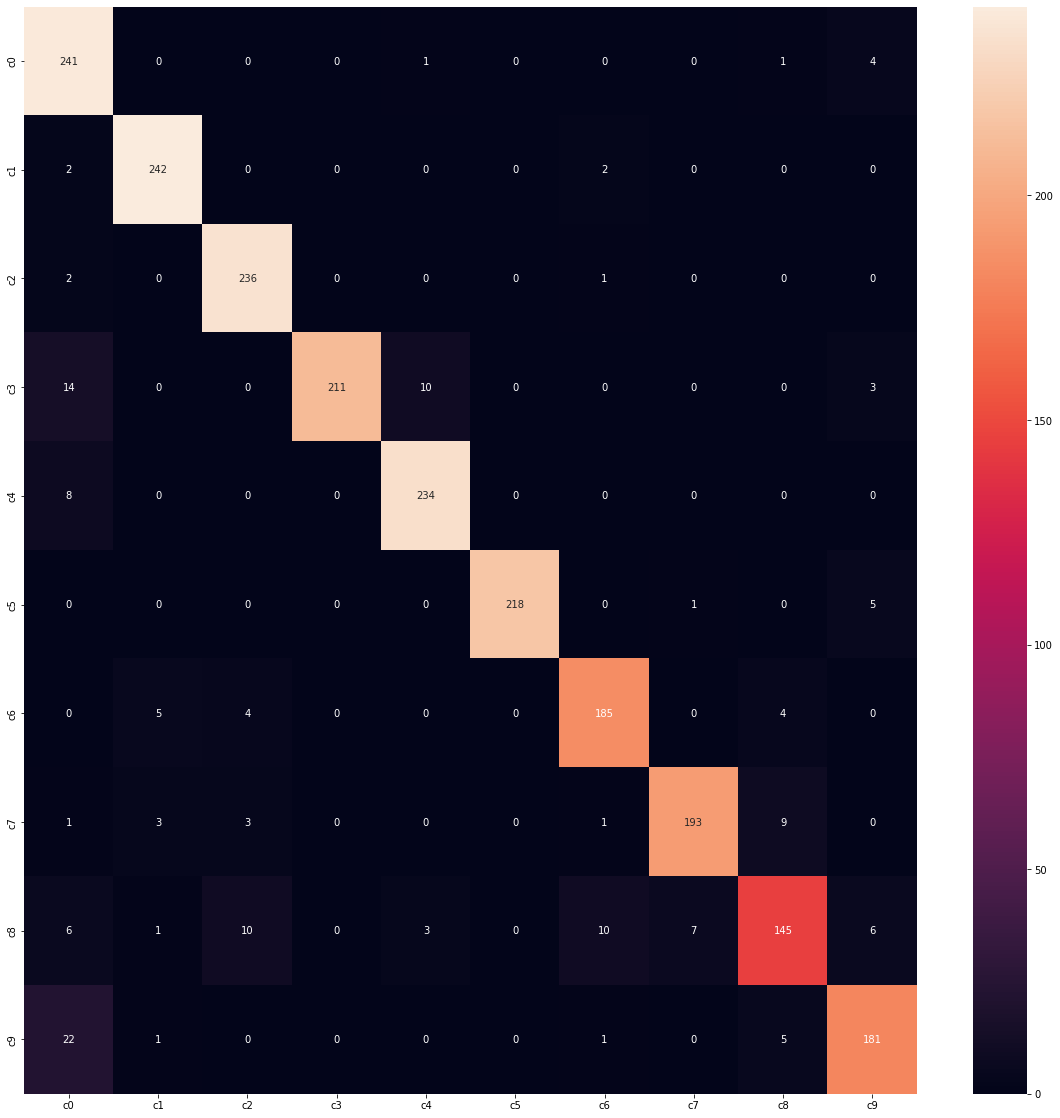

In [62]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = class_names,  columns = class_names)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, fmt='g')

In [61]:
df_cm

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
c0,241,0,0,0,1,0,0,0,1,4
c1,2,242,0,0,0,0,2,0,0,0
c2,2,0,236,0,0,0,1,0,0,0
c3,14,0,0,211,10,0,0,0,0,3
c4,8,0,0,0,234,0,0,0,0,0
c5,0,0,0,0,0,218,0,1,0,5
c6,0,5,4,0,0,0,185,0,4,0
c7,1,3,3,0,0,0,1,193,9,0
c8,6,1,10,0,3,0,10,7,145,6
c9,22,1,0,0,0,0,1,0,5,181


In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          c0       0.81      0.98      0.89       247
          c1       0.96      0.98      0.97       246
          c2       0.93      0.99      0.96       239
          c3       1.00      0.89      0.94       238
          c4       0.94      0.97      0.96       242
          c5       1.00      0.97      0.99       224
          c6       0.93      0.93      0.93       198
          c7       0.96      0.92      0.94       210
          c8       0.88      0.77      0.82       188
          c9       0.91      0.86      0.89       210

    accuracy                           0.93      2242
   macro avg       0.93      0.93      0.93      2242
weighted avg       0.93      0.93      0.93      2242



In [54]:
#Melakukan saving model kedalam folder my model
!mkdir -p saved_model
model2.save('saved_model/my_model3')

INFO:tensorflow:Assets written to: saved_model/my_model3/assets


In [55]:
#Melakukan Zip dari model yang sudah disave
!zip -r /content/my_model3.zip /content/saved_model/my_model3


  adding: content/saved_model/my_model3/ (stored 0%)
  adding: content/saved_model/my_model3/variables/ (stored 0%)
  adding: content/saved_model/my_model3/variables/variables.index (deflated 66%)
  adding: content/saved_model/my_model3/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/saved_model/my_model3/keras_metadata.pb (deflated 92%)
  adding: content/saved_model/my_model3/assets/ (stored 0%)
  adding: content/saved_model/my_model3/saved_model.pb (deflated 90%)


In [56]:
#Melakukan download dari model.zip ke dalam local data untuk digunakan lebih lanjut
from google.colab import files
files.download("/content/my_model3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>